In [11]:
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
import numpy as np
import pandas as pd


# Following functions are used to convert a value to compatible tf.train.Example
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Load meta data
metadata_modelnet40 = pd.read_csv('archive/metadata_modelnet40.csv')
shape_names = np.unique(metadata_modelnet40['class'].values) 
print(shape_names)

# Trace
print('Tracing class index for mantel ...')
arr_index = np.where(shape_names == 'mantel')
print(arr_index)
print(shape_names[arr_index])
print('Tracing class index for bookshelf ...')
arr_index = np.where(shape_names == 'bookshelf')
print(arr_index)
print(shape_names[arr_index])

# Create tf records
#nR = 11 # For spft
nR = 7   # For paper RSCNN
N = 64


#sp_multispectral_img_folder = 'extracted_multispectral_sp_images/'
#record_folder = 'extracted_tfrecords_clean/'
#sp_multispectral_img_folder = 'extracted_multispectral_sp_noise_images/'
#record_folder = 'extracted_tfrecords_noise/'
#sp_multispectral_img_folder = 'extracted_multispectral_sp_missing_images/'
#record_folder = 'extracted_tfrecords_missing/'
#sp_multispectral_img_folder = 'extracted_multispectral_sp_outliers_images/'
#record_folder = 'extracted_tfrecords_outliers/'
#sp_multispectral_img_folder = 'extracted_multispectral_sp_rot_noise_images/'
#record_folder = 'extracted_tfrecords_rot_noise/'
#sp_multispectral_img_folder = 'extracted_rscnn_sp_images/'
#record_folder = 'extracted_tfrecords_rscnn_clean/'
sp_multispectral_img_folder = 'extracted_rscnn_sp_rot_noise_images/'
record_folder = 'extracted_tfrecords_rscnn_rot_noise/'

['airplane' 'bathtub' 'bed' 'bench' 'bookshelf' 'bottle' 'bowl' 'car'
 'chair' 'cone' 'cup' 'curtain' 'desk' 'door' 'dresser' 'flower' 'glass'
 'guitar' 'keyboard' 'lamp' 'laptop' 'mantel' 'monitor' 'night' 'person'
 'piano' 'plant' 'radio' 'range' 'sink' 'sofa' 'stairs' 'stool' 'table'
 'tent' 'toilet' 'tv' 'vase' 'wardrobe' 'xbox']
Tracing class index for mantel ...
(array([21], dtype=int64),)
['mantel']
Tracing class index for bookshelf ...
(array([4], dtype=int64),)
['bookshelf']


In [13]:
nR

7

In [14]:
metadata_modelnet40.index

RangeIndex(start=0, stop=12311, step=1)

In [15]:
tf.__version__
arr1 = metadata_modelnet40.groupby('split').groups['train']
arr2 = metadata_modelnet40.groupby('split').groups['test']
arr1, arr2

(Int64Index([  100,   101,   102,   103,   104,   105,   106,   107,   108,
               109,
             ...
             12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309,
             12310],
            dtype='int64', length=9843),
 Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                 9,
             ...
             12198, 12199, 12200, 12201, 12202, 12203, 12204, 12205, 12206,
             12207],
            dtype='int64', length=2468))

In [16]:
def create_feature(row_id):
    file_folder = sp_multispectral_img_folder
    file_folder = file_folder + metadata_modelnet40['class'][row_id] + '/' + metadata_modelnet40['split'][row_id] + '/'

    obj_class = str(metadata_modelnet40['class'][row_id])    
    class_index = np.where(shape_names == obj_class)
    #print(class_index[0][0])
    feature = {
        'fname': _bytes_feature(bytes(obj_class,encoding='utf8')),
        'y': _int64_feature(class_index[0][0])
        }

    for r in range(nR):
        xval = str(r+1)
        file_name = file_folder + metadata_modelnet40['object_id'][row_id] + '_r' + xval + '.csv'
        #print(file_name)
        sp_spec_img = pd.read_csv(file_name, header=None).to_numpy().reshape([N, N])
        #print(sp_spec_img.shape)
        #sp_spec_img = np.transpose(sp_spec_img)
        if(r == 1):
            plt.imshow(sp_spec_img)
        feature['x' + str(r) ] = _bytes_feature(sp_spec_img.tostring())

    #print(feature)
    return tf.train.Example(features=tf.train.Features(feature=feature))
    

In [17]:
from tqdm import tqdm

In [18]:
np.random.rand()

0.014055375444975926

C:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


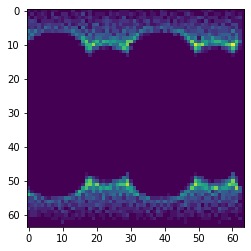

In [19]:
tf_example = create_feature(12111)

100%|████████████████████████████████████████████████████████████████████████████| 12311/12311 [11:08<00:00, 18.41it/s]


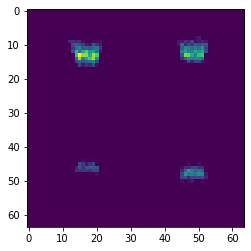

In [21]:
filename_train = record_folder + 'train.tfrecord'
filename_test = record_folder + 'test.tfrecord'
filename_val = record_folder + 'val.tfrecord'

writer_train = tf.io.TFRecordWriter(filename_train) 
writer_test = tf.io.TFRecordWriter(filename_test)
writer_val = tf.io.TFRecordWriter(filename_val)

for row_id in tqdm(metadata_modelnet40.index):
    split_ = metadata_modelnet40['split'][row_id]
    tf_example = create_feature(row_id)
    
    if(split_ == 'train'):
        if(np.random.rand() < .875):
            writer_train.write(tf_example.SerializeToString())
        else:
            writer_val.write(tf_example.SerializeToString())
    else:
        writer_test.write(tf_example.SerializeToString())

writer_train.close()
writer_test.close()
writer_val.close()